In [1]:
import pandas as pd
import numpy as np
from ipynb.fs.defs.Preprocessing_Module import read_data, add_topological, add_landcover, select_columns, reshape_dataset, fillna_dataset
from ipynb.fs.defs.Feature_Expansion_Module2 import feature_expansion
from ipynb.fs.defs.Initializer_Module import initializer
from ipynb.fs.defs.XGboost_Model_Module import Xgboost_model
from ipynb.fs.defs.Model_Validation_Module import test_model_random_split, train_model_KFold, operational_validation, predict

In [2]:
import warnings
warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True)

In [3]:
data = read_data('../Datasets/Italy/Veneto/Culex/IT_veneto_culex_2010_2022.csv')
#=====================================================================
data = data[data.trap_type != 'Gravid Trap']
data = data.reset_index(drop=True)
#=====================================================================
columns = ['dt_placement', 'x', 'y', 'culex.spp', 'ndvi', 'ndwi', 'ndmi', 'ndbi',
           'ndvi_mean', 'ndvi_std', 'ndwi_mean', 'ndwi_std', 'ndmi_mean',
           'ndmi_std', 'ndbi_mean', 'ndbi_std', 'lst_day', 'lst_night',
           'acc_rainfall_1week', 'acc_rainfall_2week', 'acc_rainfall_jan',
           'lst_jan_day_mean', 'lst_feb_day_mean', 'lst_mar_day_mean', 'lst_apr_day_mean',
           'lst_jan_night_mean', 'lst_feb_night_mean', 'lst_mar_night_mean', 'lst_apr_night_mean']
names = ['dt_placement', 'x', 'y', 'mosq_now', 'ndvi', 'ndwi', 'ndmi', 'ndbi',
         'ndvi_mean', 'ndvi_std', 'ndwi_mean', 'ndwi_std', 'ndmi_mean',
         'ndmi_std', 'ndbi_mean', 'ndbi_std', 'lst_day', 'lst_night',
         'acc_rainfall_1week', 'acc_rainfall_2week', 'acc_rainfall_jan',
         'lst_jan_day_mean', 'lst_feb_day_mean', 'lst_mar_day_mean', 'lst_apr_day_mean',
         'lst_jan_night_mean', 'lst_feb_night_mean', 'lst_mar_night_mean', 'lst_apr_night_mean']
data = select_columns(data,columns,names)
data = add_topological(data,'../Datasets/Topological Datasets/2x2grid/Italy_veneto_2km_geo.csv')
data = add_landcover(data,'../Datasets/Landcover Datasets/2x2grid/Italy_veneto_2km_lulc.csv')
data = reshape_dataset(data,['x','y','dt_placement'])
data = fillna_dataset(data,{'acc_rainfall_1week':0, 'acc_rainfall_2week':0, 'acc_rainfall_jan':0})

Index(['station_id', 'x', 'y', 'dt_placement', 'week', 'month', 'year',
       'country_code', 'nuts0_code', 'nuts0_name', 'nuts1_code', 'nuts1_name',
       'nuts2_code', 'nuts2_name', 'nuts3_code', 'nuts3_name',
       'lau1_municipality', 'lau2_settlement', 'trap_type', 'culex.spp',
       'region', 'dt_placement_original', 'indices_image_date', 'indices_lat',
       'indices_lon', 'ndvi', 'ndmi', 'ndwi', 'ndbi', 'ndvi_mean', 'ndmi_mean',
       'ndwi_mean', 'ndbi_mean', 'ndvi_std', 'ndmi_std', 'ndwi_std',
       'ndbi_std', 'lst_image_date', 'lst_lat', 'lst_lon', 'lst_day',
       'lst_night', 'monthly_lst_lat', 'monthly_lst_lon', 'lst_jan_day_mean',
       'lst_jan_night_mean', 'lst_feb_day_mean', 'lst_feb_night_mean',
       'lst_mar_day_mean', 'lst_mar_night_mean', 'lst_apr_day_mean',
       'lst_apr_night_mean', 'indices_image_date.1', 'indices_lat.1',
       'indices_lon.1', 'acc_rainfall_jan', 'dt_placement_minus_7',
       'dt_placement_minus_14', 'dt_placement_minus_7_avail

In [4]:
# set the only_env as True if you want to use only environmental features
only_env = True
# set the case title
case_title = 'xgboost class regression'
# set the exp as True if you want to save the results as csv
exp = False
# set the filepath to export the data
path = '../Results/Italy/Veneto/Culex/'
# set the name of the date column
date_col = 'dt_placement'
# set the model type. Could be 'class_regression' or 'mosquito_regression' or 'classification'
model_type = 'class_regression'
#set the data for embeddings e.g. data[['col', 'col2']]
embedded_data = None
#set the transformation actions of the data. Options are 'augmentation', 'normalization', 'log', 'scaling'
transformation_list = []

In [5]:
previous = read_data('../Datasets/Italy/Veneto/Culex/veneto_previous.csv')
previous

Index(['dt_placement', 'x', 'y', 'region', 'ndvi', 'ndmi', 'ndwi', 'ndbi',
       'ndvi_mean', 'ndmi_mean', 'ndwi_mean', 'ndbi_mean', 'ndvi_std',
       'ndmi_std', 'ndwi_std', 'ndbi_std', 'indices_image_date', 'lst_day',
       'lst_night', 'rainfall'],
      dtype='object')


,dt_placement,x,y,region,ndvi,ndmi,ndwi,ndbi,ndvi_mean,ndmi_mean,ndwi_mean,ndbi_mean,ndvi_std,ndmi_std,ndwi_std,ndbi_std,indices_image_date,lst_day,lst_night,rainfall
0,2010-01-05,10.643895,45.455490,veneto,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13880.0,13750.0,6.280650
1,2010-01-06,10.643895,45.455490,veneto,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13880.0,13750.0,0.180082
2,2010-01-07,10.643895,45.455490,veneto,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13906.0,13750.0,7.332737
3,2010-01-08,10.643895,45.455490,veneto,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13906.0,13750.0,8.073555
4,2010-01-09,10.643895,45.455490,veneto,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13906.0,13750.0,38.276075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135051,2022-12-08,13.522398,45.941135,veneto,0.554024,0.218267,-0.444541,-0.218267,0.474166,0.148259,-0.375882,-0.148259,0.060644,0.039849,0.042926,0.039849,2022-12-04,14181.0,13720.0,0.000000
135052,2022-12-06,13.614180,45.960976,veneto,0.451777,0.126667,-0.358918,-0.126667,0.433852,0.121257,-0.330106,-0.121257,0.099672,0.047850,0.088706,0.047850,2022-12-04,14167.0,13770.0,0.000000
135053,2022-12-07,13.614180,45.960976,veneto,0.451777,0.126667,-0.358918,-0.126667,0.433852,0.121257,-0.330106,-0.121257,0.099672,0.047850,0.088706,0.047850,2022-12-04,14167.0,13770.0,0.000000
135054,2022-12-08,13.614180,45.960976,veneto,0.451777,0.126667,-0.358918,-0.126667,0.433852,0.121257,-0.330106,-0.121257,0.099672,0.047850,0.088706,0.047850,2022-12-04,14167.0,13770.0,0.000000


In [6]:
data = feature_expansion(data, previous, env=only_env)

In [7]:
data

,x,y,dt_placement,mosq_now,ndvi,ndwi,ndmi,ndbi,ndvi_mean,ndvi_std,...,mean_temp_-5_days,mean_temp_-10_days,mean_temp_-15_days,mean_temp_-30_days,30_days_mean_ndvi,30_days_mean_ndmi,30_days_mean_ndwi,30_days_mean_ndbi,next_5_days_mean_lst,next_5_days_sum_rainfall
0,10.643895,45.455490,2010-05-10,1.0,0.333217,-0.037408,0.190331,-0.190331,0.217599,0.174718,...,16.035000,16.966000,17.557000,15.722273,0.189839,0.337208,0.218468,-0.337208,14.170000,7.445368
1,10.643895,45.455490,2010-06-21,2.0,0.237465,0.018893,0.217427,-0.217427,0.236604,0.252246,...,22.211667,22.918889,23.156667,22.837391,0.229167,0.258281,0.087412,-0.258281,21.428333,6.518762
2,10.643895,45.455490,2010-07-05,12.0,NaN,NaN,NaN,NaN,NaN,NaN,...,27.285000,24.765714,23.118333,23.404783,0.236604,0.219164,0.024957,-0.219164,26.572500,16.985497
3,10.643895,45.455490,2010-07-19,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,28.133333,27.988571,27.473636,24.980870,0.236604,0.219164,0.024957,-0.219164,26.868333,27.500562
4,10.643895,45.455490,2010-08-02,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,22.822500,24.092222,25.167857,26.155217,NaN,NaN,NaN,NaN,23.630000,77.012597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7827,13.614180,45.960976,2021-04-11,NaN,0.406300,-0.401395,0.016092,-0.016092,0.442102,0.087407,...,NaN,13.860000,14.603333,10.053500,0.418552,0.050357,-0.370106,-0.050357,9.710000,92.284183
7828,13.614180,45.960976,2022-06-12,NaN,0.478697,-0.417891,0.226328,-0.226328,0.518677,0.093054,...,19.663333,20.175000,19.988750,20.535652,0.491254,0.212849,-0.411564,-0.212849,23.860000,9.961795
7829,13.614180,45.960976,2022-07-11,NaN,0.517203,-0.472616,0.107717,-0.107717,0.532026,0.152758,...,25.395000,25.395000,25.390000,24.552273,0.496550,0.164844,-0.440326,-0.164844,21.400000,3.155647
7830,13.614180,45.960976,2022-08-14,NaN,0.440808,-0.419530,0.033121,-0.033121,0.470465,0.156694,...,26.883333,27.508333,28.148750,27.763478,0.515967,0.121136,-0.459712,-0.121136,24.653333,165.444437


In [8]:
data = initializer(data, model_type, 10, dropna=True)

Bounds: [   0.    4.    9.   18.   33.   56.   93.  155.  266.  535. 7463.]


In [9]:
data.columns

Index(['x', 'y', 'dt_placement', 'ndvi', 'ndwi', 'ndmi', 'ndbi', 'ndvi_mean',
       'ndvi_std', 'ndwi_mean', 'ndwi_std', 'ndmi_mean', 'ndmi_std',
       'ndbi_mean', 'ndbi_std', 'lst_day', 'lst_night', 'acc_rainfall_1week',
       'acc_rainfall_2week', 'acc_rainfall_jan', 'lst_jan_day_mean',
       'lst_feb_day_mean', 'lst_mar_day_mean', 'lst_apr_day_mean',
       'lst_jan_night_mean', 'lst_feb_night_mean', 'lst_mar_night_mean',
       'lst_apr_night_mean', 'DISTANCE_TO_COAST', 'DISTANCE_TO_RIVER',
       'SLOPE_mean_1km', 'ASPECT_mean_200m', 'ELEVATION_mean_1km',
       'HILLSHADE_mean_1km', 'FS_AREA_1km', 'FLOW_ACCU_200m', 'landcover',
       'null_island_distance', 'vert_distance', 'days_distance', 'mo_sin',
       'mo_cos', 'lst', 'days_with_temp>10', 'days_with_temp>20',
       'days_with_temp>30', 'days_with_temp>25_jan', 'mean_temp_-5_days',
       'mean_temp_-10_days', 'mean_temp_-15_days', 'mean_temp_-30_days',
       '30_days_mean_ndvi', '30_days_mean_ndmi', '30_days_mean_nd

In [13]:
data2 = data[['x', 'y', 'dt_placement', 'ndvi', 'ndwi', 'ndmi', 'ndbi', 'ndvi_mean',
       'ndvi_std', 'ndwi_mean', 'ndwi_std', 'ndmi_mean', 'ndmi_std',
       'ndbi_mean', 'ndbi_std', 'lst_day', 'lst_night', 'acc_rainfall_1week',
       'acc_rainfall_2week', 'acc_rainfall_jan', 'lst_jan_day_mean',
       'lst_feb_day_mean', 'lst_mar_day_mean', 'lst_apr_day_mean',
       'lst_jan_night_mean', 'lst_feb_night_mean', 'lst_mar_night_mean',
       'lst_apr_night_mean', 'DISTANCE_TO_COAST', 'DISTANCE_TO_RIVER',
       'SLOPE_mean_1km', 'ASPECT_mean_200m', 'ELEVATION_mean_1km',
       'HILLSHADE_mean_1km', 'FS_AREA_1km', 'FLOW_ACCU_200m', 'landcover',
       'null_island_distance', 'vert_distance', 'days_distance', 'mo_sin',
       'mo_cos', 'lst', 'days_with_temp>10', 'days_with_temp>20',
       'days_with_temp>30', 'days_with_temp>25_jan', 'mosq_now']]

In [14]:
model = Xgboost_model(model_type = model_type, learning_rate = 0.3,
                      embedding_data = embedded_data,  transformation_list = transformation_list,
                      early_stop = False, l1_weight = 0, l2_weight = 0, weights = False)

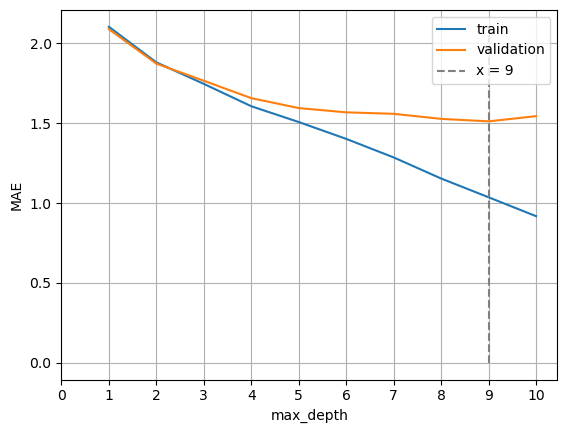

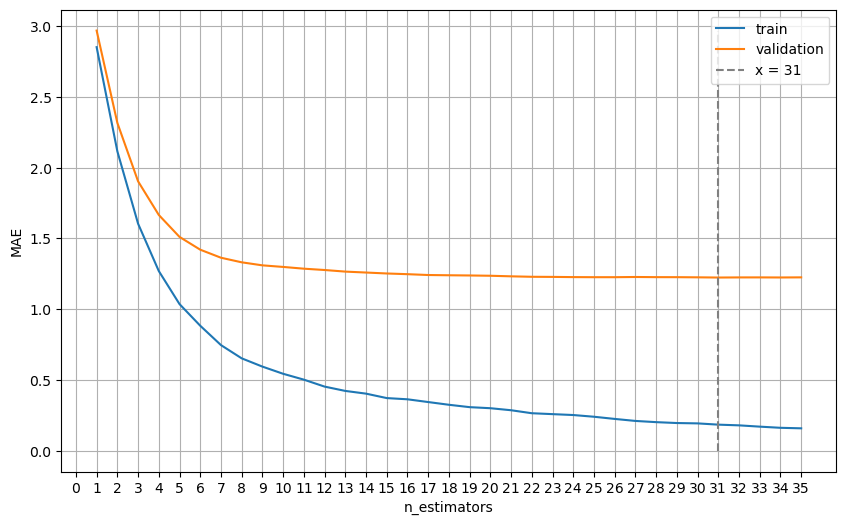

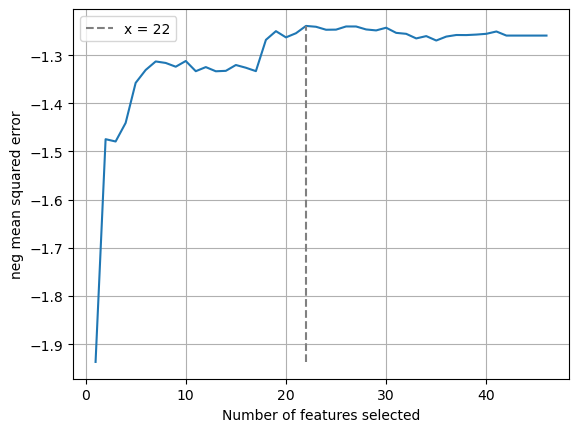

max_depth:  9
Number of estimators:  31
Selected_features:  Index(['lst_apr_day_mean', 'lst_jan_night_mean', 'lst_feb_night_mean',
       'lst_mar_night_mean', 'lst_apr_night_mean', 'DISTANCE_TO_COAST',
       'DISTANCE_TO_RIVER', 'SLOPE_mean_1km', 'ASPECT_mean_200m',
       'ELEVATION_mean_1km', 'HILLSHADE_mean_1km', 'FS_AREA_1km',
       'FLOW_ACCU_200m', 'landcover', 'null_island_distance', 'days_distance',
       'mo_cos', 'lst', 'days_with_temp>10', 'days_with_temp>20',
       'days_with_temp>30', 'days_with_temp>25_jan'],
      dtype='object')


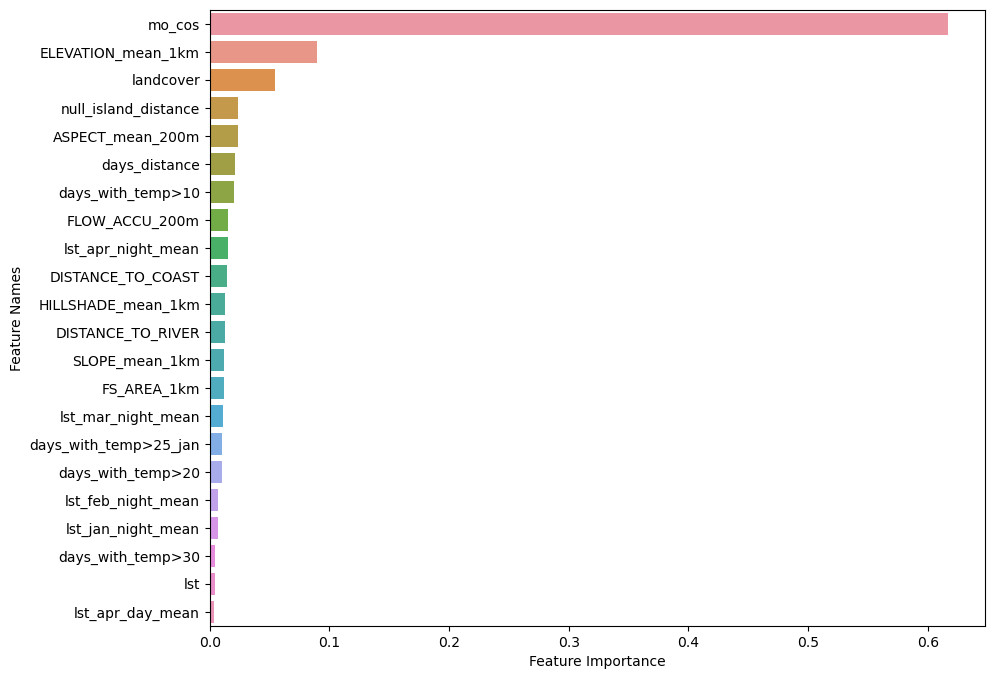

MAE on train set:  0.22474942174248266
min prediction: 0.0
max prediction: 9.0

MAE on test set:  1.2365506329113924
Error <= 3: 95.97 %
min prediction: 0.0
max prediction: 9.0


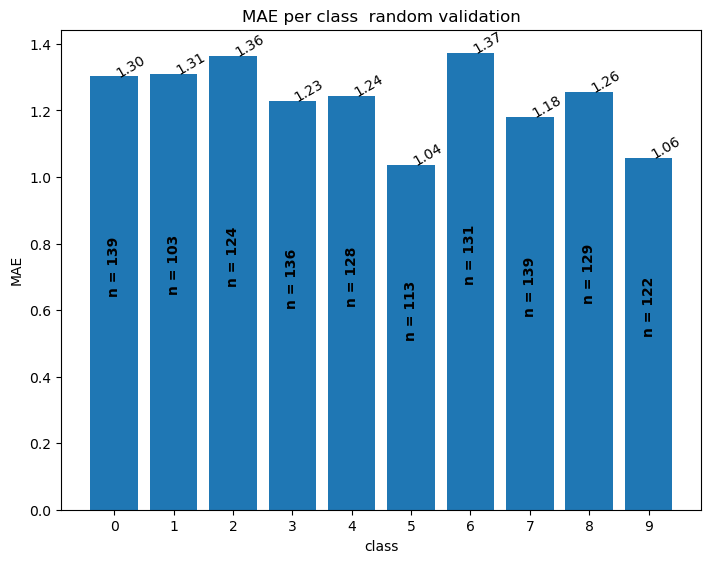

-----------|class error-MAE| difference-----------
mean: 0.18185480830810333
std: 0.1025193081643076
coefficient of variation (std/mean): 0.5637426313777562

----------normalized difference-------------
mean: 0.5742745596483119
std: 0.3237430513894415
coefficient of variation (std/mean): 0.563742631377756


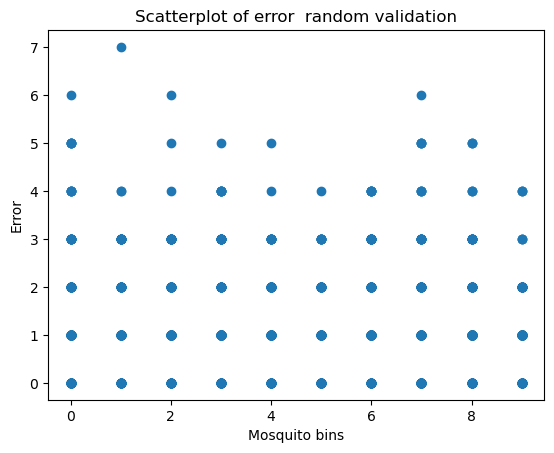

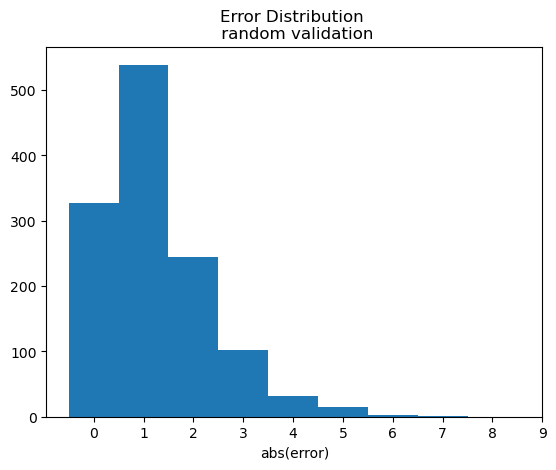

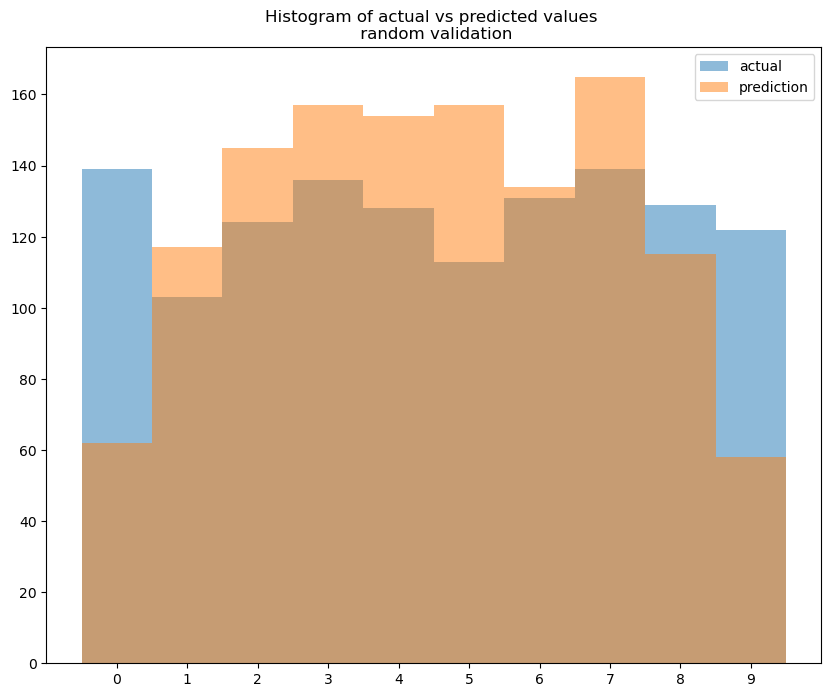

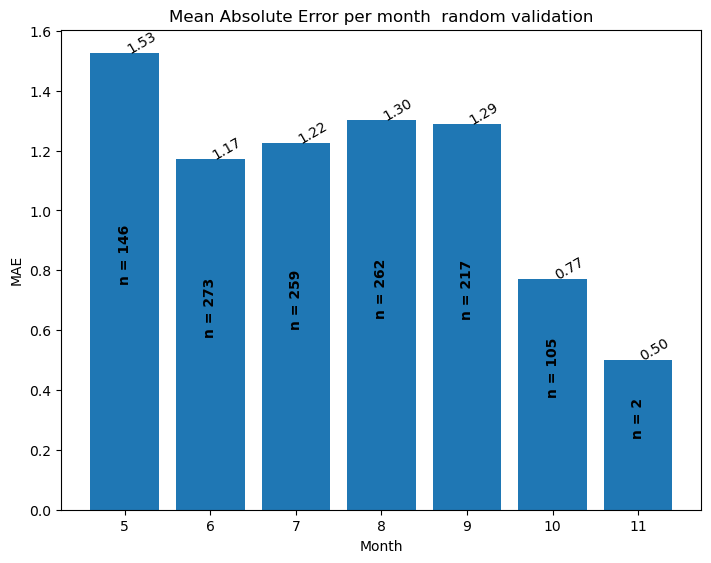

In [15]:
test_model_random_split(data2, model, filepath = '', date_col = date_col, case='', fi = True, export=exp)

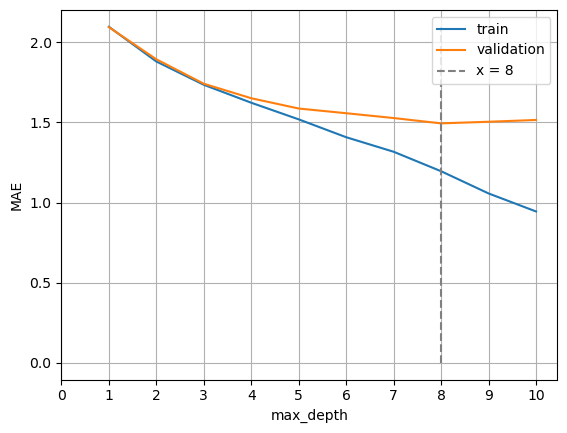

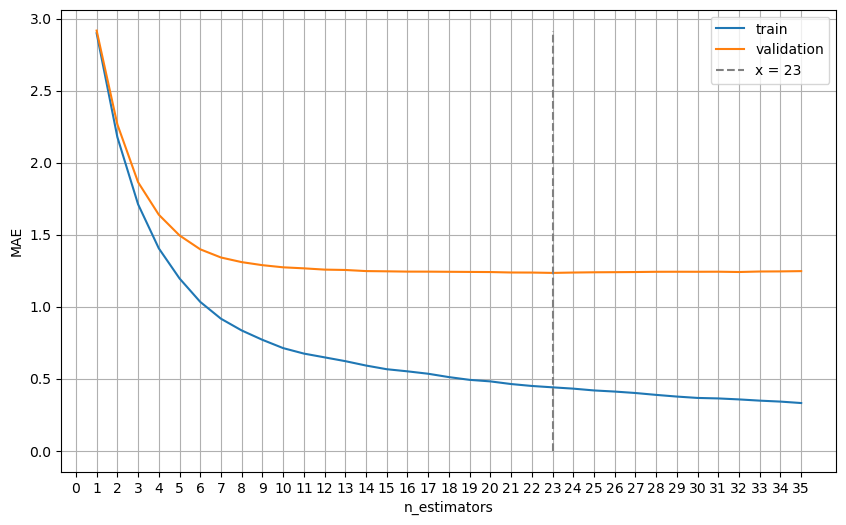

max_depth:  8
Number of estimators:  23
Selected_features:  ['x', 'y', 'ndvi', 'ndwi', 'ndmi', 'ndbi', 'ndvi_mean', 'ndvi_std', 'ndwi_mean', 'ndwi_std', 'ndmi_mean', 'ndmi_std', 'ndbi_mean', 'ndbi_std', 'lst_day', 'lst_night', 'acc_rainfall_1week', 'acc_rainfall_2week', 'acc_rainfall_jan', 'lst_jan_day_mean', 'lst_feb_day_mean', 'lst_mar_day_mean', 'lst_apr_day_mean', 'lst_jan_night_mean', 'lst_feb_night_mean', 'lst_mar_night_mean', 'lst_apr_night_mean', 'DISTANCE_TO_COAST', 'DISTANCE_TO_RIVER', 'SLOPE_mean_1km', 'ASPECT_mean_200m', 'ELEVATION_mean_1km', 'HILLSHADE_mean_1km', 'FS_AREA_1km', 'FLOW_ACCU_200m', 'landcover', 'null_island_distance', 'vert_distance', 'days_distance', 'mo_sin', 'mo_cos', 'lst', 'summer_days_year', 'summer_days_month']
MAE on train set:  0.42883234111304286
min prediction: 0.0
max prediction: 9.0

MAE on test set:  1.206733048838312
Error <= 3: 96.57 %
min prediction: 0.0
max prediction: 9.0


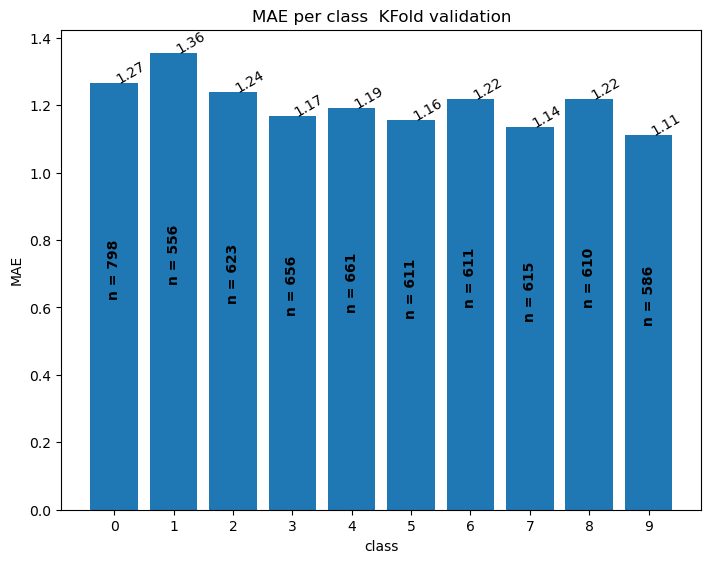

-----------|class error-MAE| difference-----------
mean: 0.09531453743167184
std: 0.06757765405206151
coefficient of variation (std/mean): 0.7089962966090657

----------normalized difference-------------
mean: 0.38873174103541946
std: 0.27560936476850684
coefficient of variation (std/mean): 0.7089962966090658


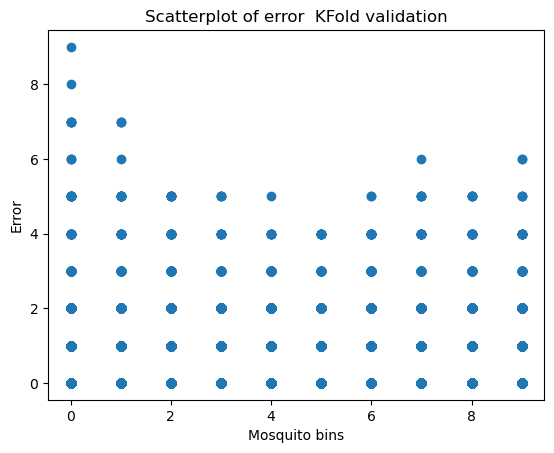

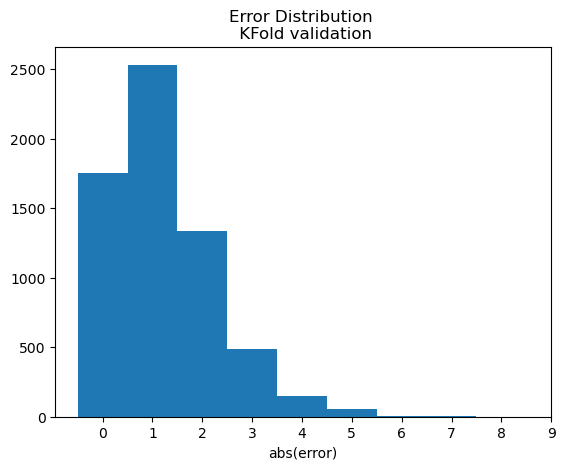

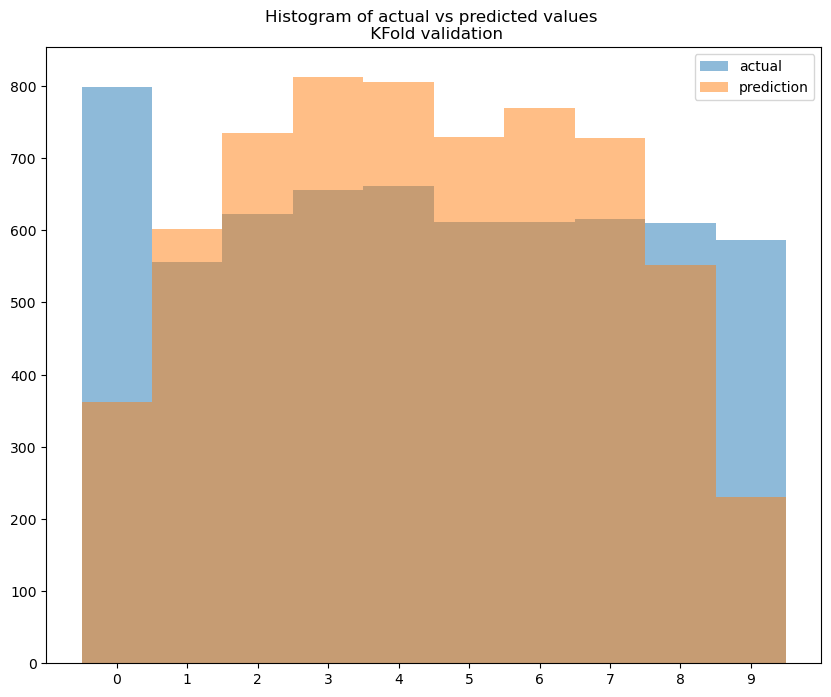

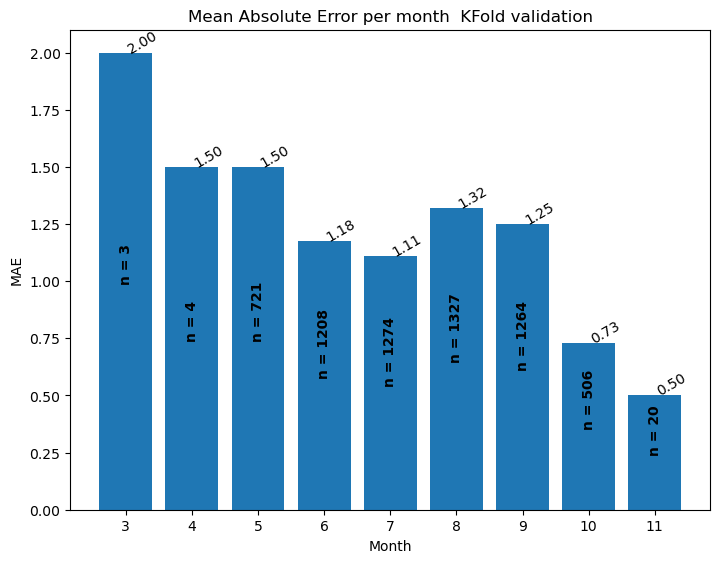

In [9]:
train_model_KFold(data, model, date_col=date_col)

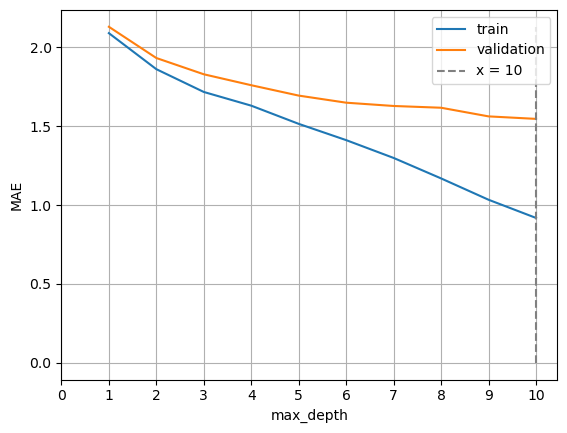

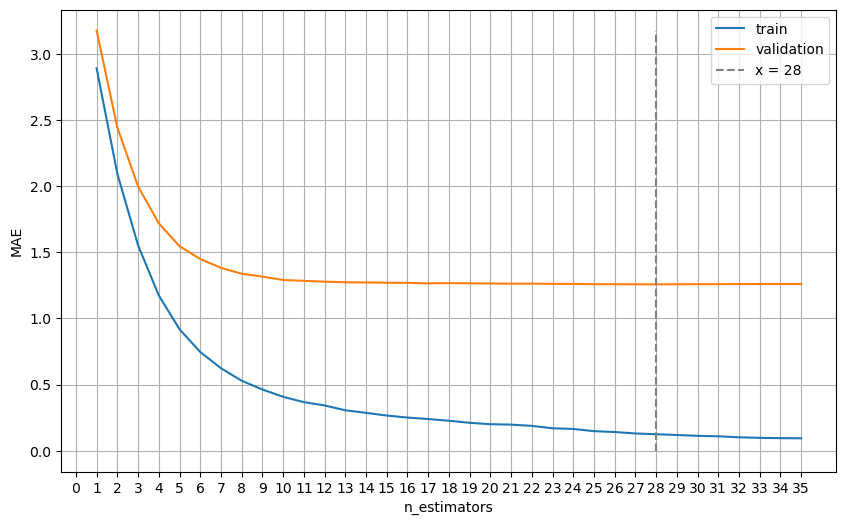

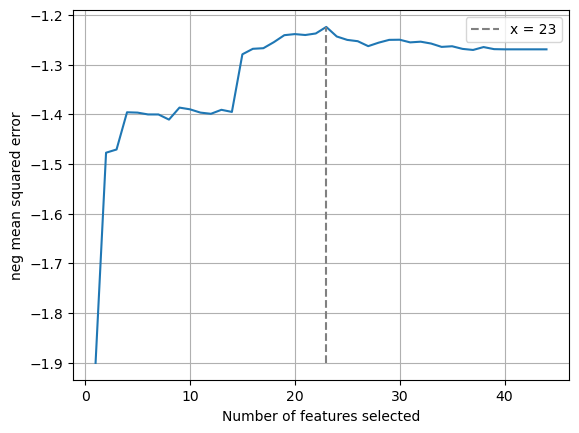

max_depth:  10
Number of estimators:  28
Selected_features:  Index(['acc_rainfall_jan', 'lst_jan_day_mean', 'lst_feb_day_mean',
       'lst_mar_day_mean', 'lst_apr_day_mean', 'lst_jan_night_mean',
       'lst_feb_night_mean', 'lst_mar_night_mean', 'lst_apr_night_mean',
       'DISTANCE_TO_COAST', 'DISTANCE_TO_RIVER', 'SLOPE_mean_1km',
       'ASPECT_mean_200m', 'ELEVATION_mean_1km', 'HILLSHADE_mean_1km',
       'FS_AREA_1km', 'FLOW_ACCU_200m', 'landcover', 'null_island_distance',
       'days_distance', 'mo_cos', 'lst', 'summer_days_year'],
      dtype='object')


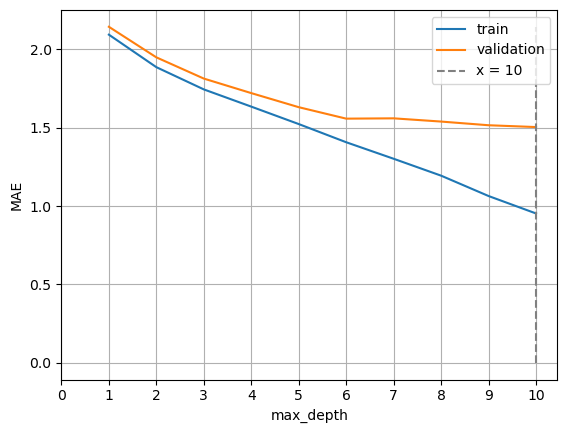

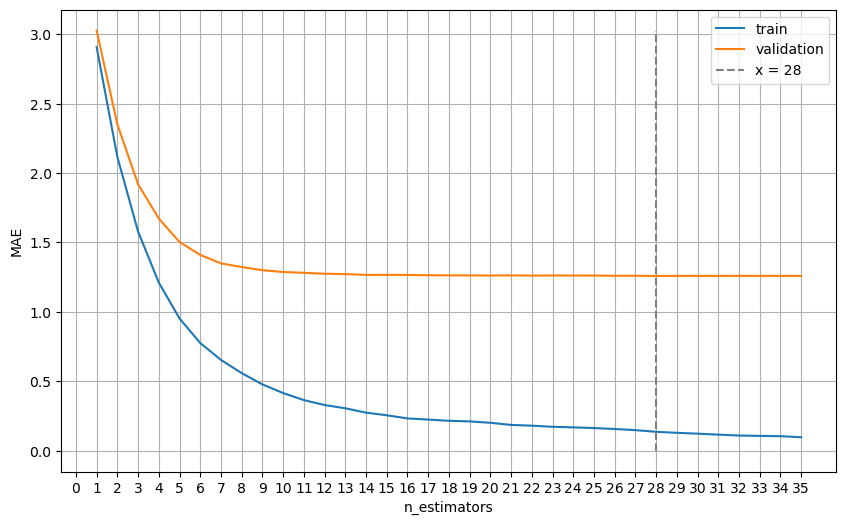

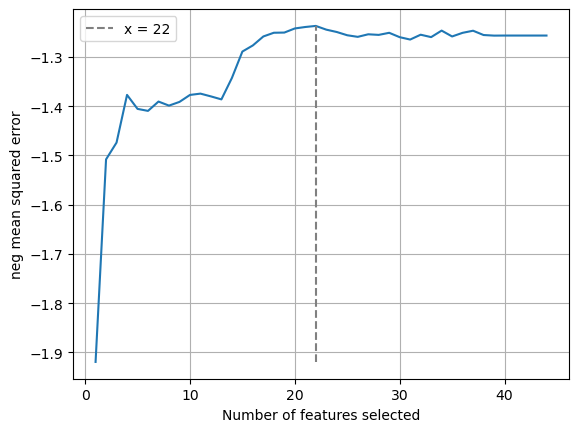

max_depth:  10
Number of estimators:  28
Selected_features:  Index(['acc_rainfall_jan', 'lst_jan_day_mean', 'lst_feb_day_mean',
       'lst_mar_day_mean', 'lst_apr_day_mean', 'lst_jan_night_mean',
       'lst_feb_night_mean', 'lst_mar_night_mean', 'lst_apr_night_mean',
       'DISTANCE_TO_COAST', 'DISTANCE_TO_RIVER', 'SLOPE_mean_1km',
       'ASPECT_mean_200m', 'ELEVATION_mean_1km', 'HILLSHADE_mean_1km',
       'FS_AREA_1km', 'FLOW_ACCU_200m', 'landcover', 'null_island_distance',
       'days_distance', 'mo_cos', 'lst'],
      dtype='object')


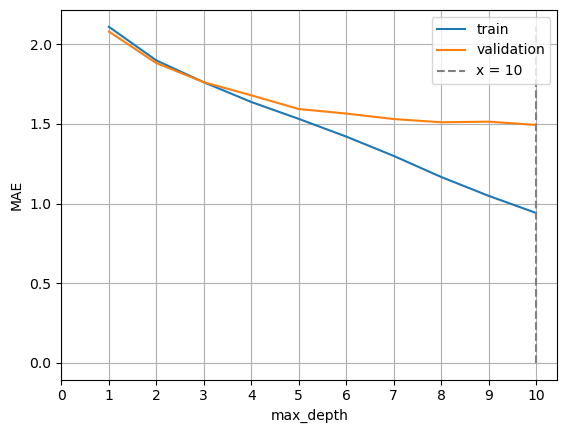

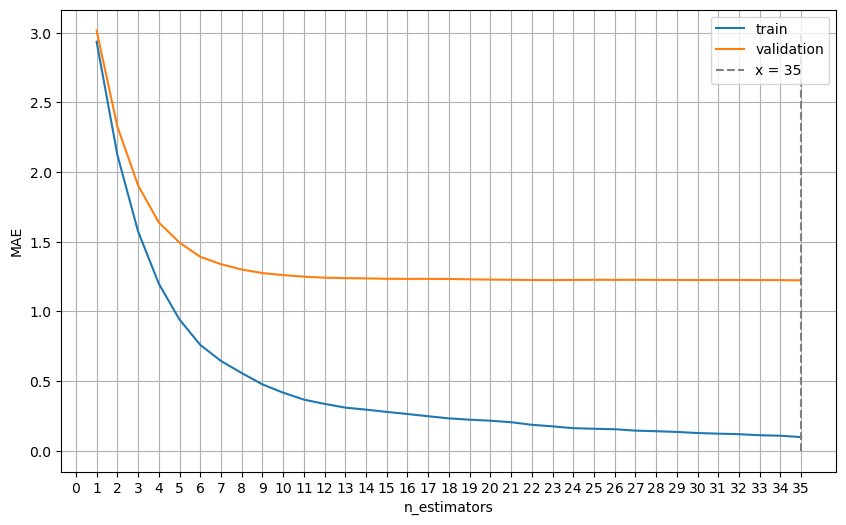

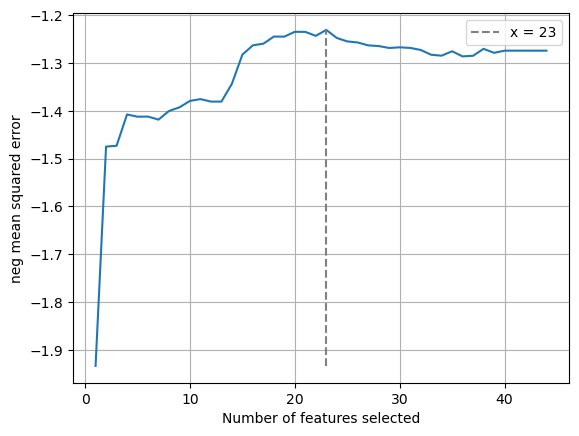

max_depth:  10
Number of estimators:  35
Selected_features:  Index(['acc_rainfall_jan', 'lst_jan_day_mean', 'lst_feb_day_mean',
       'lst_mar_day_mean', 'lst_apr_day_mean', 'lst_jan_night_mean',
       'lst_feb_night_mean', 'lst_mar_night_mean', 'lst_apr_night_mean',
       'DISTANCE_TO_COAST', 'DISTANCE_TO_RIVER', 'SLOPE_mean_1km',
       'ASPECT_mean_200m', 'ELEVATION_mean_1km', 'HILLSHADE_mean_1km',
       'FS_AREA_1km', 'FLOW_ACCU_200m', 'landcover', 'null_island_distance',
       'days_distance', 'mo_cos', 'lst', 'summer_days_year'],
      dtype='object')


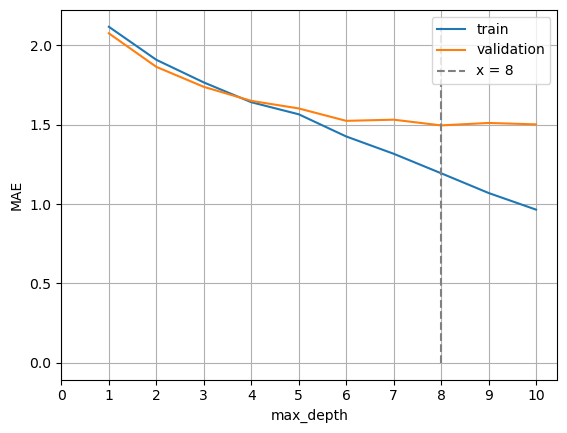

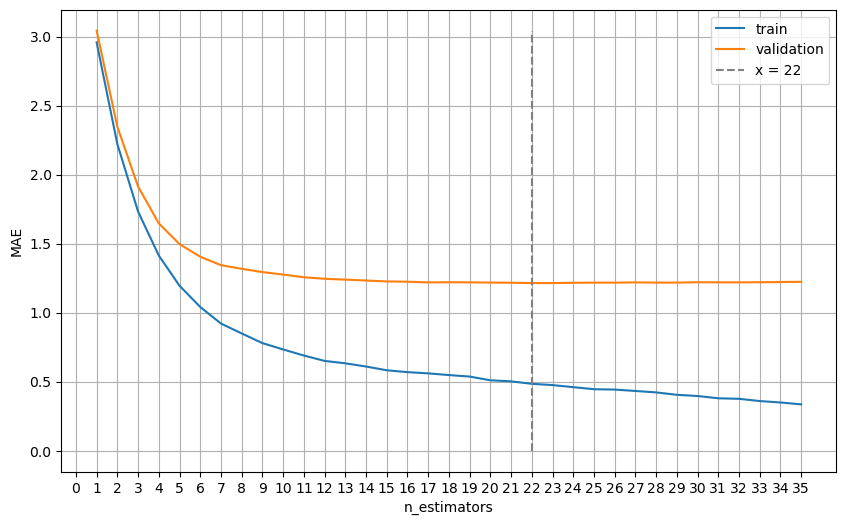

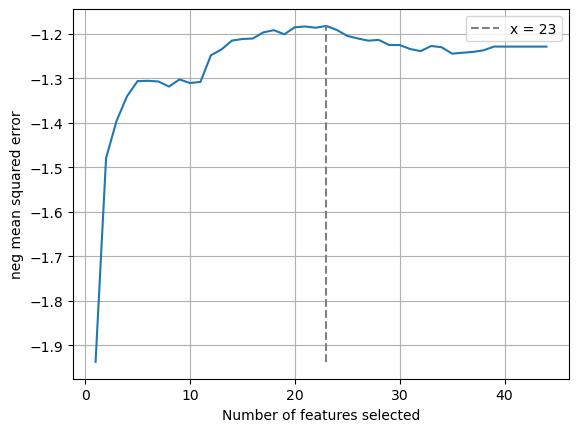

max_depth:  8
Number of estimators:  22
Selected_features:  Index(['x', 'y', 'acc_rainfall_jan', 'lst_jan_day_mean', 'lst_feb_day_mean',
       'lst_mar_day_mean', 'lst_apr_day_mean', 'lst_jan_night_mean',
       'lst_feb_night_mean', 'lst_mar_night_mean', 'lst_apr_night_mean',
       'DISTANCE_TO_COAST', 'DISTANCE_TO_RIVER', 'SLOPE_mean_1km',
       'ASPECT_mean_200m', 'ELEVATION_mean_1km', 'HILLSHADE_mean_1km',
       'FS_AREA_1km', 'FLOW_ACCU_200m', 'landcover', 'null_island_distance',
       'days_distance', 'mo_cos'],
      dtype='object')


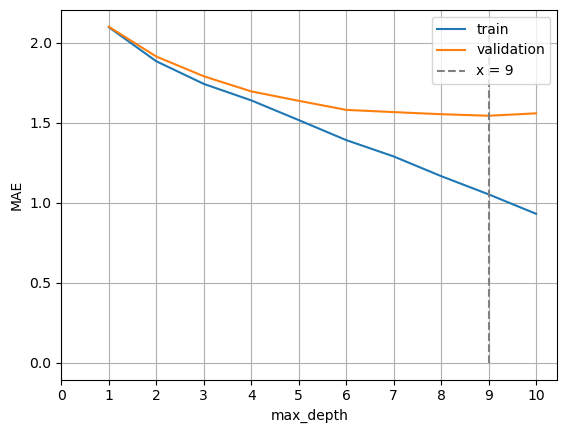

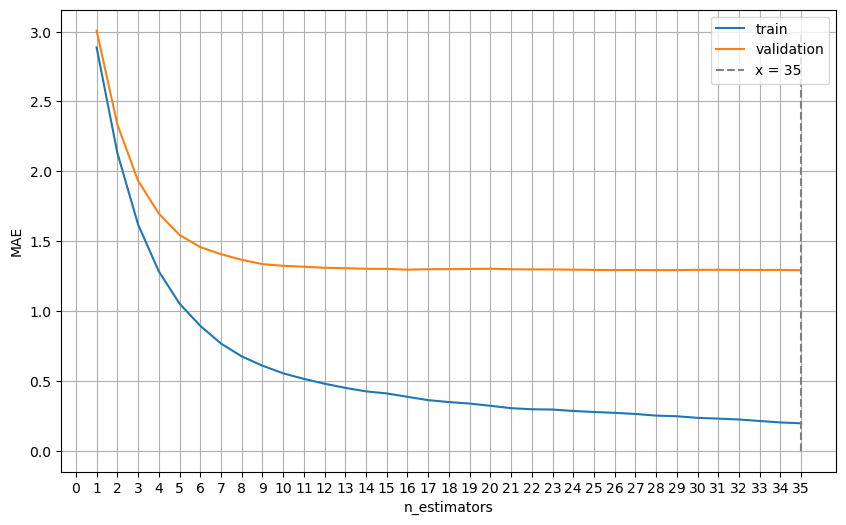

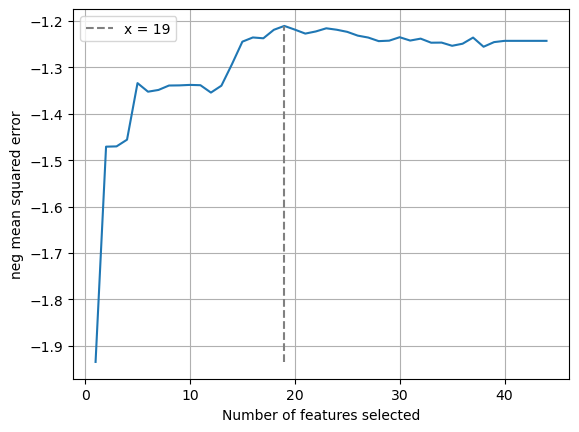

max_depth:  9
Number of estimators:  35
Selected_features:  Index(['lst_mar_day_mean', 'lst_apr_day_mean', 'lst_jan_night_mean',
       'lst_feb_night_mean', 'lst_mar_night_mean', 'lst_apr_night_mean',
       'DISTANCE_TO_COAST', 'DISTANCE_TO_RIVER', 'SLOPE_mean_1km',
       'ASPECT_mean_200m', 'ELEVATION_mean_1km', 'HILLSHADE_mean_1km',
       'FS_AREA_1km', 'FLOW_ACCU_200m', 'landcover', 'null_island_distance',
       'days_distance', 'mo_cos', 'lst'],
      dtype='object')
MAE on train set:  0.2127321850726106
min prediction: 0.0
max prediction: 9.0

MAE on test set:  1.3966244725738397
Error <= 3: 95.36 %
min prediction: 0.0
max prediction: 9.0


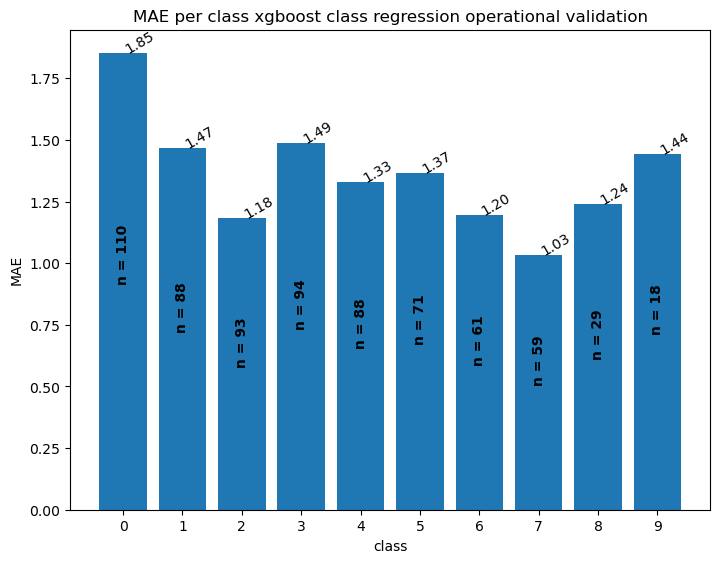

-----------|class error-MAE| difference-----------
mean: 0.17926123174417777
std: 0.14430871323836267
coefficient of variation (std/mean): 0.8050190876982506

----------normalized difference-------------
mean: 0.43664089016586416
std: 0.351504251053076
coefficient of variation (std/mean): 0.8050190876982505


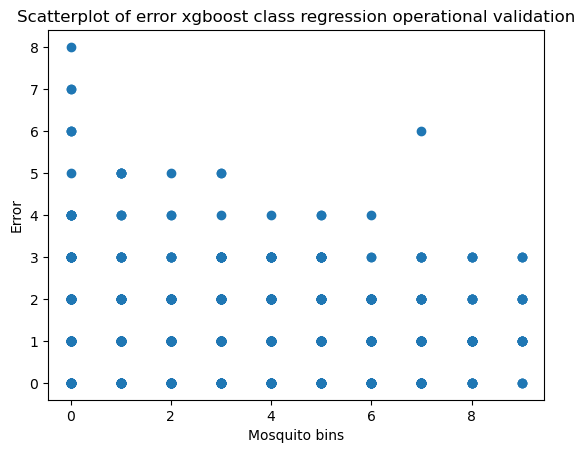

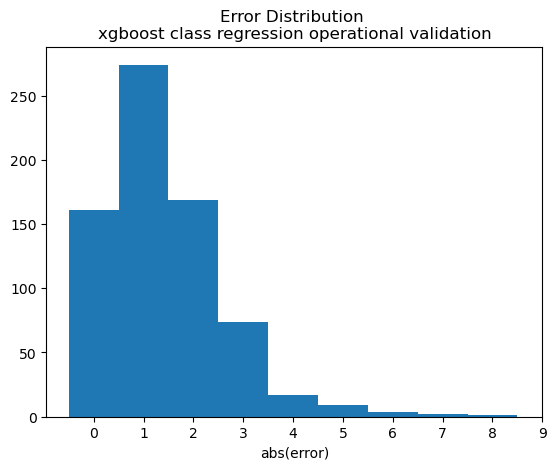

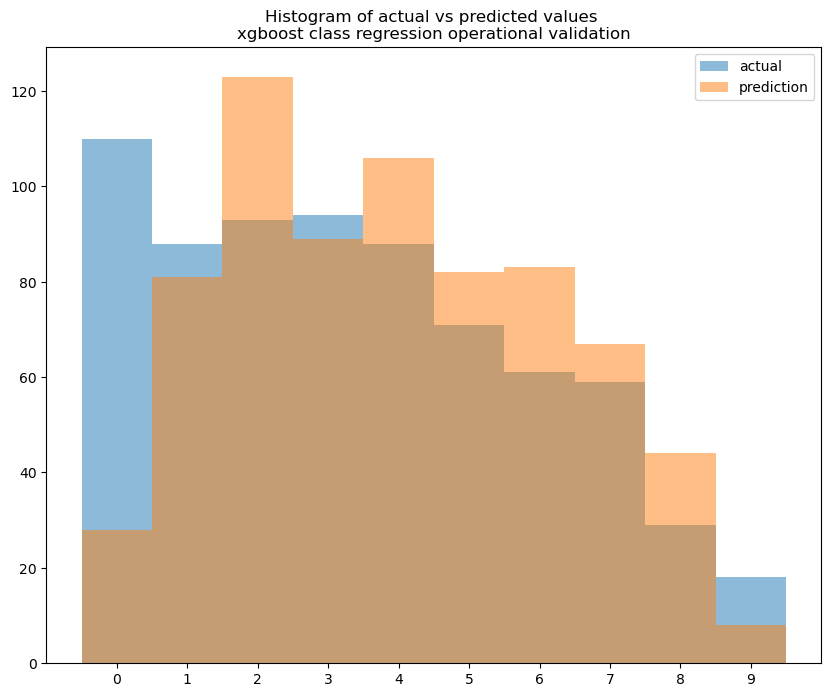

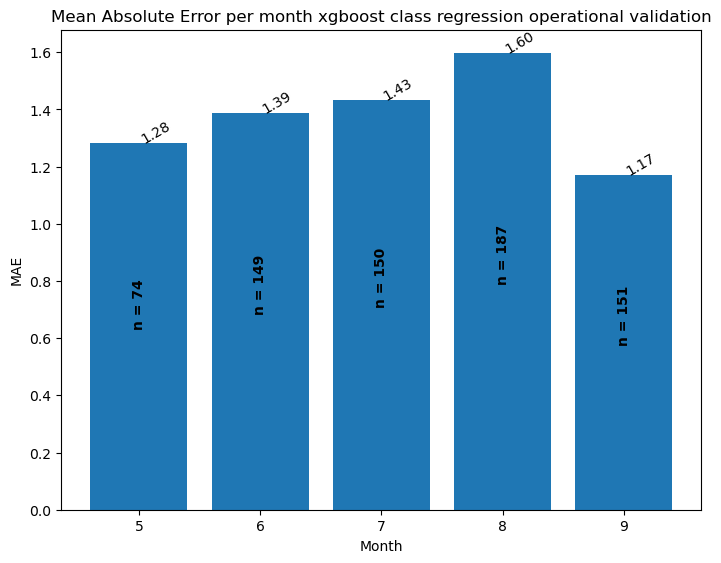

In [8]:
operational_validation(data, model, filepath = path, date_col = date_col,
                       date = '2022-01-01', case = case_title, export= exp)

operational validation:
stable features: 
    MAE on train set:  0.12279635258358662
    MAE on test set:  1.481012658227848
    Error <= 3: 93.95 %
All features:
    MAE on train set:  0.04893617021276596
    MAE on test set:  1.5119549929676512
    Error <= 3: 92.41 %
different fatures:
    MAE on train set:  0.2127321850726106
    MAE on test set:  1.3966244725738397
    Error <= 3: 95.36 %